In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

titanic = pd.read_csv('titanic_train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # 테스트 데이터에 관해서는 fit으로 학습하지 않음
    def fit(self, X, y = None):
        pass
    
    # Sex feature 값이 1이면(남자이면) 0을, 값이 1이 아니면(여자이면) 1로 예측함
    # 남자이면 살아 있지 못하고 여자이면 살아 있을 거라고 단순히 예측하는 방식
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [3]:
from sklearn.preprocessing import LabelEncoder

# 결측지 대체
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위에서 정의한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 입력 데이터(X_titanic)와 결과 데이터(y_titanic) 분할
# 데이터에 따른 'Survived' 값 예측 모델
y_titanic = titanic['Survived']
X_titanic = titanic.drop('Survived', axis = 1)
X_titanic = transform_features(X_titanic)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size = 0.2, random_state = 0)

In [5]:
my_clf = MyDummyClassifier()
my_clf.fit(X_train, y_train)

my_prediction = my_clf.predict(X_test)
print('MyDummyClassifier의 정확도: {0:.4f}'.format(accuracy_score(y_test, my_prediction)))

MyDummyClassifier의 정확도: 0.7877


In [6]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    def predict(sel, X):
        return np.zeros((len(X), 1), dtype = bool)

In [7]:
# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [8]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 데이터 세트 크기: ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습 / 예측 / 정확도 평가
fake_clf = MyFakeClassifier()
fake_clf.fit(X_train, y_train)
fake_pred = fake_clf.predict(X_test)
print('모든 예측을 0으로 했을 때의 정확도: {:.3f}'.format(accuracy_score(y_test, fake_pred)))

레이블 데이터 세트 크기:  (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 했을 때의 정확도: 0.900


In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fake_pred)

array([[405,   0],
       [ 45,   0]])

In [10]:
from sklearn.metrics import precision_score, recall_score

# 오차 행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수
# y_test: 테스트 데이터의 실제 값
# pred: 테스트 데이터를 모델에서 테스트했을 때의 예측값
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [11]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측 후 위의 평가를 진행
from sklearn.linear_model import LogisticRegression

titanic = pd.read_csv('titanic_train.csv')
y_titanic = titanic['Survived']
X_titanic = titanic.drop('Survived', axis=1)
X_titanic = transform_features(X_titanic)

X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression(max_iter=5000)

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [12]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n', pred_proba[:3])
print('\n')
# 예측 확률 array와 예측 결과값 array를 concatenate하여 예측 확률과 결과값을 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측함\n', pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
 [[0.46213804 0.53786196]
 [0.87867086 0.12132914]
 [0.87716628 0.12283372]]


두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측함
 [[0.46213804 0.53786196 1.        ]
 [0.87867086 0.12132914 0.        ]
 [0.87716628 0.12283372 0.        ]]


In [13]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [14]:
# Binarizer의 threshold 설정값, 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 컬럼
# 즉, positive 클래스 컬럼 하나만 추출하여 Binarizer 적용함
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [15]:
# 임계값 = 0.4

custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [16]:
# 테스트를 수행할 모든 임계값 리스트화
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # threshold list 객체 내의 값을 차례로 iteration 하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값: ',custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print('\n')
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값:  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


임계값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033


임계값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


임계값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541


임계값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377




In [17]:
# 타이타닉 예측 모델의 임계값 별 정밀도, 재현율
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)
print('반환된 정밀도 배열의 shape: ', precisions.shape)
print('반환된 재현율 배열의 shape: ', recalls.shape)
print('')

print('임계값 5 sample: ', thresholds[:5])
print('정밀도 5 sample: ', precisions[:5])
print('재현율 5 sample: ', recalls[:5])
print('')

# 반환된 임계값 배열의 행 수가 143이므로 샘플로 10건만 추출, 임계값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))
print('')

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 shape: (143,)
반환된 정밀도 배열의 shape:  (144,)
반환된 재현율 배열의 shape:  (144,)

임계값 5 sample:  [0.10393179 0.10393407 0.10395969 0.10785113 0.108903  ]
정밀도 5 sample:  [0.38853503 0.38461538 0.38709677 0.38961039 0.38562092]
재현율 5 sample:  [1.         0.98360656 0.98360656 0.98360656 0.96721311]

샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]

샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


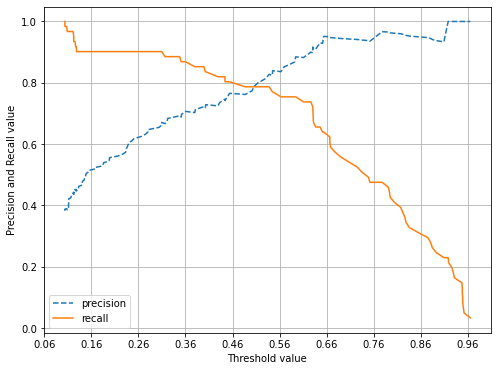

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로 Y축을 정밀도, 재현율 값으로 각각 plot 수행 (정밀도는 점선으로 표현)
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print(f'f1 score: {f1:.3f}') # f-string format

f1 score: 0.780


In [20]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값:  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727


임계값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840


임계값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805


임계값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931


임계값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036




In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_class1)

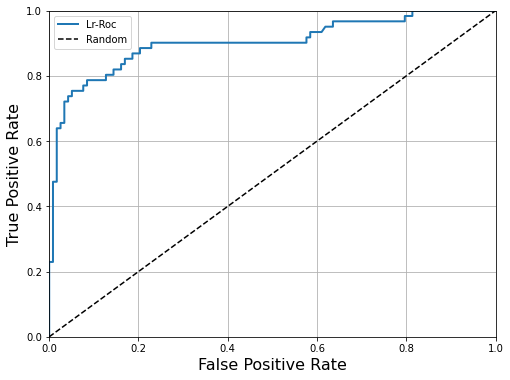

In [22]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.legend(['Lr-Roc', 'Random'], loc='best')
plt.show()

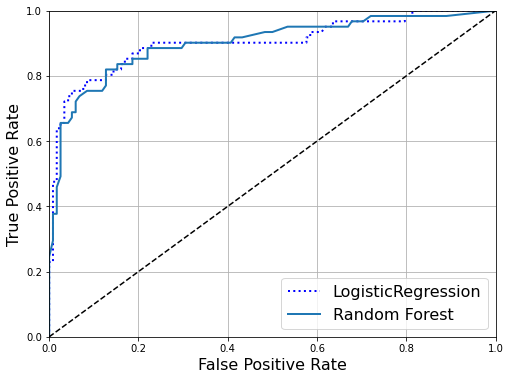

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_clf.fit(X_train, y_train)
y_probas_forest = forest_clf.predict_proba(X_test)

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_scores_forest)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "LogisticRegression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc = "best", fontsize = 16)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
fr_pred_proba = forest_clf.predict_proba(X_test)[:,1]
lr_roc_score = roc_auc_score(y_test, lr_pred_proba)
fr_roc_score = roc_auc_score(y_test, fr_pred_proba)
print("lr_ROC AUC 값: {0:.4f}".format(lr_roc_score))
print("fr_ROC AUC 값: {0:.4f}".format(fr_roc_score))

lr_ROC AUC 값: 0.9024
fr_ROC AUC 값: 0.9001


In [25]:
from sklearn.preprocessing import StandardScaler

diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
def get_clf_eval2(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred_proba)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_score))
    

X = diabetes.iloc[:, :-1]
y = diabetes.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 156, stratify = y)

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval2(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8072


In [27]:
def get_eval_by_threshold2(y_test, pred_proba_c1, thresholds):
    # threshold list 객체 내의 값을 차례로 iteration 하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값: ',custom_threshold)
        get_clf_eval2(y_test, custom_predict, pred_proba_c1)
        print('\n')

thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold2(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)

임계값:  0.3
오차 행렬
[[69 31]
 [12 42]]
정확도: 0.7208, 정밀도: 0.5753, 재현율: 0.7778, F1: 0.6614, AUC: 0.8072


임계값:  0.33
오차 행렬
[[74 26]
 [17 37]]
정확도: 0.7208, 정밀도: 0.5873, 재현율: 0.6852, F1: 0.6325, AUC: 0.8072


임계값:  0.36
오차 행렬
[[76 24]
 [18 36]]
정확도: 0.7273, 정밀도: 0.6000, 재현율: 0.6667, F1: 0.6316, AUC: 0.8072


임계값:  0.39
오차 행렬
[[80 20]
 [19 35]]
정확도: 0.7468, 정밀도: 0.6364, 재현율: 0.6481, F1: 0.6422, AUC: 0.8072


임계값:  0.42
오차 행렬
[[81 19]
 [20 34]]
정확도: 0.7468, 정밀도: 0.6415, 재현율: 0.6296, F1: 0.6355, AUC: 0.8072


임계값:  0.45
오차 행렬
[[85 15]
 [20 34]]
정확도: 0.7727, 정밀도: 0.6939, 재현율: 0.6296, F1: 0.6602, AUC: 0.8072


임계값:  0.48
오차 행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500, 재현율: 0.6111, F1: 0.6735, AUC: 0.8072


임계값:  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8072


